# SpatialEddy flux data access tutorial
This notebook reads a multiband GeoTIFF raster, visualizes a single timeslice, applies a quality mask, and prints spatial information.

In [41]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from pathlib import Path


### Create Paths

In [90]:
dir_path = Path("/data-benchflux") # Replace this with your actual base location of the downloaded dataset
site = ("JORN", "STEI", "STER", "TREE")[1] # choice of NEON sites
flux = ("fluxCo2", "fluxH2oEngy", "fluxTempEngy")[0] # choice of fluxes
date = "20190701" # choose a valid date (in 2019... more years will be available in the future)

raster_file = f"{site.lower()}_{flux}_{date}.tif"
quality_flag_file = f"{site.lower()}_{flux}_{date}_qa.tif"

raster_path = dir_path / site / flux / raster_file
quality_flag_path = dir_path / site / flux / quality_flag_file


### Explore a single geotiff

Each geotiff file has 48 bands, which correspond to 48 half-hours of flux data.

Below we'll open a geotiff for a single day of the year (lets do July 1st) and print the geospatial information from the fluxmap. Note that this information (spatial extent and CRS) will be the same for any individual geotiff file within the same site. 

***Reminder:** We are looking at one day of data. You can repeat these steps on any other day of the year, just change the **date** variable in the code cell above.*

In [55]:
with rasterio.open(raster_path) as src:
    print("CRS:", src.crs)
    print("Bounds:", src.bounds)
    print("Number of bands:", src.count)

CRS: EPSG:32616
Bounds: BoundingBox(left=294959.1, bottom=5039734.8, right=300979.1, top=5045734.8)
Number of bands: 48


Print the band names. Each band name is a half hourly timeslice in the **UTC** timezone.

In [57]:
ds = gdal.Open(str(raster_path))
print("Number of bands:", ds.RasterCount)

for i in range(1, ds.RasterCount + 1):
    band = ds.GetRasterBand(i)
    band_description = band.GetDescription()
    print(f"Band {i}: {band_description}")



Number of bands: 48
Band 1: 2019-07-02T00:00:00Z
Band 2: 2019-07-02T00:30:00Z
Band 3: 2019-07-02T01:00:00Z
Band 4: 2019-07-02T01:30:00Z
Band 5: 2019-07-02T02:00:00Z
Band 6: 2019-07-02T02:30:00Z
Band 7: 2019-07-02T03:00:00Z
Band 8: 2019-07-02T03:30:00Z
Band 9: 2019-07-02T04:00:00Z
Band 10: 2019-07-02T04:30:00Z
Band 11: 2019-07-02T05:00:00Z
Band 12: 2019-07-02T05:30:00Z
Band 13: 2019-07-02T06:00:00Z
Band 14: 2019-07-02T06:30:00Z
Band 15: 2019-07-02T07:00:00Z
Band 16: 2019-07-02T07:30:00Z
Band 17: 2019-07-02T08:00:00Z
Band 18: 2019-07-02T08:30:00Z
Band 19: 2019-07-02T09:00:00Z
Band 20: 2019-07-02T09:30:00Z
Band 21: 2019-07-02T10:00:00Z
Band 22: 2019-07-02T10:30:00Z
Band 23: 2019-07-02T11:00:00Z
Band 24: 2019-07-02T11:30:00Z
Band 25: 2019-07-02T12:00:00Z
Band 26: 2019-07-02T12:30:00Z
Band 27: 2019-07-02T13:00:00Z
Band 28: 2019-07-02T13:30:00Z
Band 29: 2019-07-02T14:00:00Z
Band 30: 2019-07-02T14:30:00Z
Band 31: 2019-07-02T15:00:00Z
Band 32: 2019-07-02T15:30:00Z
Band 33: 2019-07-02T16:00:00Z

### Flux value through the day

Below we will take our single July 1st raster and calculate the spatial median of all of the pixels in each 30-min time interval of the day. Then we will plot them through time. This should help conceptualize the temporal dimension of the data.

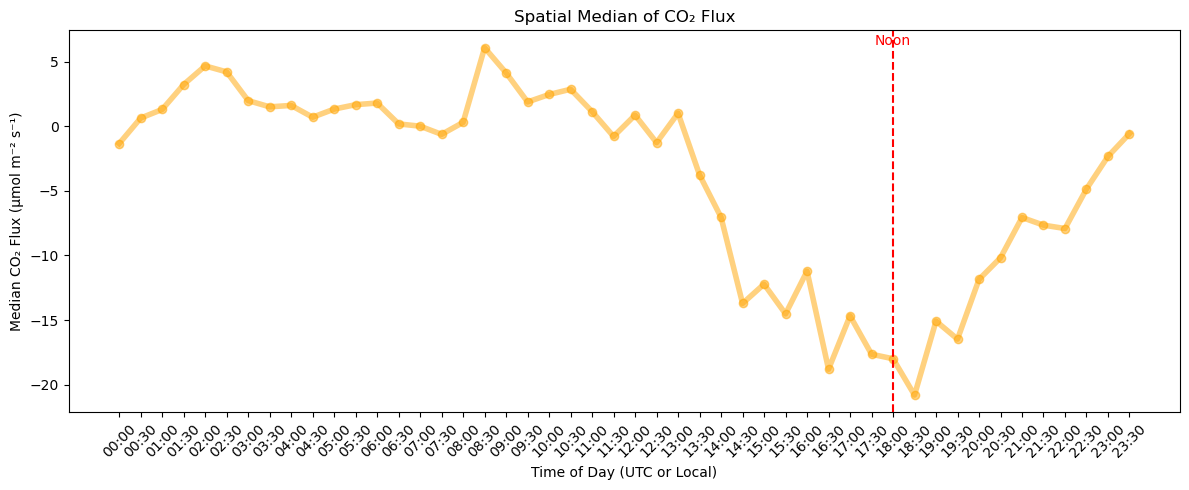

In [86]:
spatial_medians = []

with rasterio.open(raster_path) as src:
    for band_index in range(1, src.count + 1):  # 1-based indexing
        data = src.read(band_index).astype(float)
        median = np.nanmedian(data)
        spatial_medians.append(median)

times = [f"{h:02}:{m:02}" for h in range(24) for m in (0, 30)] # Create time labels for x-axis (30-min intervals)
noon_index = times.index("18:00") # optionally create an index to plot noon to contextualize the time axis

# Plot the time series
plt.figure(figsize=(12, 5))
plt.plot(times, spatial_medians, marker='o', lw = 4, alpha = 0.5, c = 'orange')
plt.xticks(rotation=45)
plt.xlabel("Time of Day (UTC or Local)")
plt.ylabel("Median CO₂ Flux (µmol m⁻² s⁻¹)")
plt.title("Spatial Median of CO₂ Flux")
plt.axvline(x=times[noon_index], color='red', linestyle='--', label="Noon CDT (18:00 UTC)") # optionally create a line to plot noon to contextualize the time axis
plt.text(times[noon_index], max(spatial_medians), "Noon", color='red', ha='center', va='bottom') # optionally create a text box to plot noon to contextualize the time axis

plt.tight_layout()
plt.show()

### Plot a timeslice

Now we will plot a single timeslice of the raster to visualize the spatial information contained in each time slice of the raster. We'll plot CET noon at our STEI location.

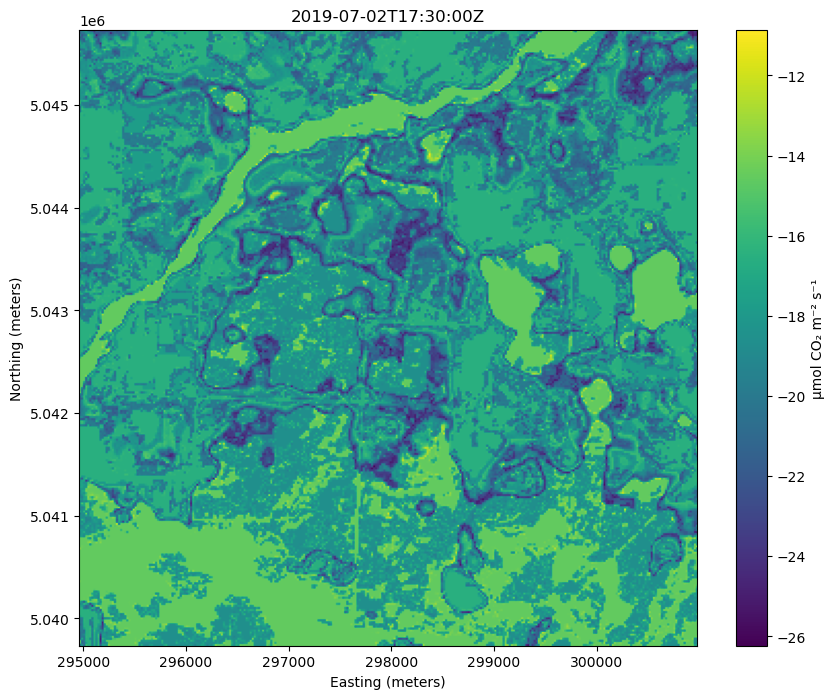

In [58]:
band_index = 37  # Change this to the band you want to visualize

# Get band description from GDAL
ds = gdal.Open(str(raster_path))
band_description = ds.GetRasterBand(band_index).GetDescription()

# Read and plot the band using rasterio
with rasterio.open(raster_path) as src:
    band_data = src.read(band_index)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    
    plt.figure(figsize=(10, 8))
    img = plt.imshow(band_data, cmap='viridis', extent=extent, origin='upper')
    plt.title(f"{band_description}")
    plt.xlabel("Easting (meters)")
    plt.ylabel("Northing (meters)")
    cbar = plt.colorbar(img, label="µmol CO₂ m⁻² s⁻¹")
    plt.grid(False)
    plt.show()


### Time series plot

Let's plot carbon flux from several slices of time throughout the day to see how the spatial patterns change with ecological cycles.

/var/folders/wc/llw7k3yj05n0nmrqg4k53xxr0000gn/T/ipykernel_67782/3956085509.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


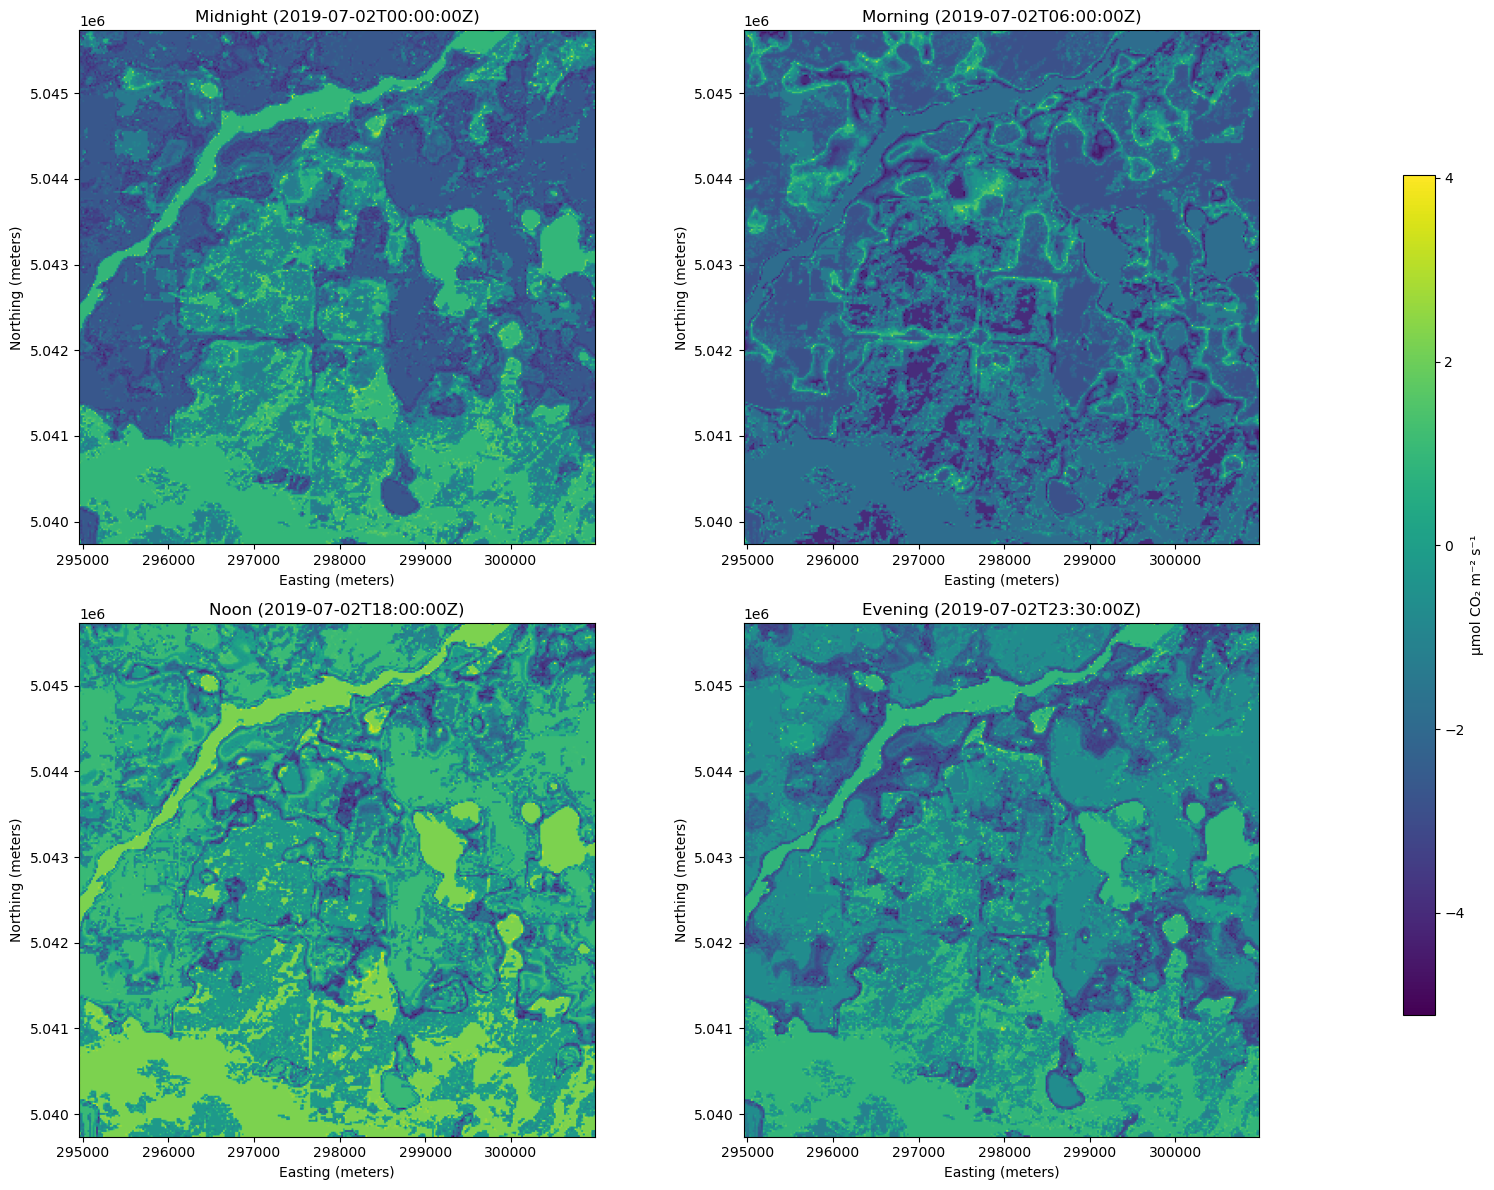

In [65]:
raster_path = str(raster_path)

band_indices = [1, 13, 37, 48]  # 00:00, 06:00, 18:00, 23:30 UTC
verbal_times = ["Midnight", "Morning", "Noon", "Evening"]

ds = gdal.Open(raster_path)

# Read and plot all bands
with rasterio.open(raster_path) as src:
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    axs = axs.flatten()

    for i, band_index in enumerate(band_indices):
        band_data = src.read(band_index)
        band_description = ds.GetRasterBand(band_index).GetDescription()  # e.g., "2025-07-15T17:30:00Z"

        axs[i].imshow(band_data, cmap='viridis', extent=extent, origin='upper')
        axs[i].set_title(f"{verbal_times[i]} ({band_description})")
        axs[i].set_xlabel("Easting (meters)")
        axs[i].set_ylabel("Northing (meters)")

    # Shared colorbar
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    fig.colorbar(axs[0].images[0], cax=cbar_ax, label="µmol CO₂ m⁻² s⁻¹")

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()


### Apply a quality flag

The SpatialEddy dataset contains a matching quality flag layer for each day of flux data. We will load this in using the **quality_flag_path** variable we created at the beginning of the tutorial.

This file contains a per-pixel quality flag (QF) for each value in the dataset. Each QF value corresponds to a level of uncertainty in the measurements — both **systematic** and **random**.

#### What does the QF value mean?

- A QF of `0` means very high confidence:
  - ~5% **systematic** uncertainty
  - ~80% **random** uncertainty
- Higher QF values mean more uncertainty. The table below shows how much uncertainty increases for each QF level.

#### Uncertainty Expansion Factors

| Quality Flag (QF) | Systematic Uncertainty | Random Uncertainty |
|-------------------|------------------------|--------------------|
| 0                 | 1×                     | 1×                 |
| 1                 | 2×                     | 1.4×               |
| 2                 | 3×                     | 1.7×               |
| 3                 | 4×                     | 2.0×               |
| 4                 | 5×                     | 2.2×               |
| 5                 | 6×                     | 2.5×               |

>  **Systematic uncertainty** increases directly.  
>  **Random uncertainty** increases more slowly, following a quadratic pattern.



Below, we will plot flux pixels with a quality flag of 2.


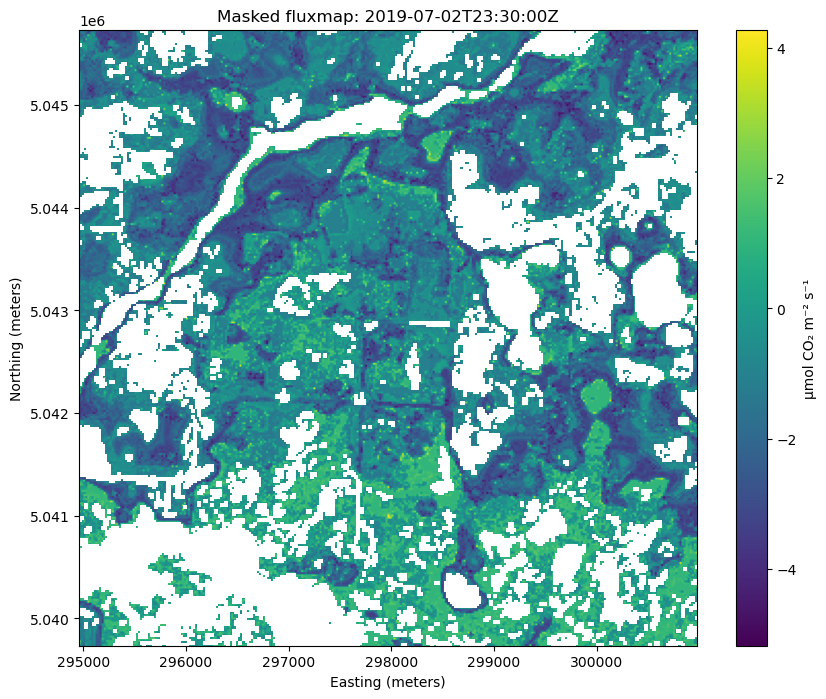

In [74]:
# Open both raster and quality flag
with rasterio.open(raster_path) as src, rasterio.open(quality_flag_path) as qf_src:
    band_data = src.read(band_index).astype(float)
    quality_data = qf_src.read(1)

    # Mask where quality flag == 2
    masked_data = np.where(quality_data == 2, np.nan, band_data)
    
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Plot
    plt.figure(figsize=(10, 8))
    img = plt.imshow(masked_data, cmap='viridis', extent=extent, origin='upper')
    plt.title(f"Masked fluxmap: {band_description}")
    plt.xlabel("Easting (meters)")
    plt.ylabel("Northing (meters)")
    cbar = plt.colorbar(img, label="µmol CO₂ m⁻² s⁻¹")
    plt.grid(False)
    plt.show()
